Show the ROC curves for the various classifiers on frb's

In [1]:
from __future__ import division
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np
import sys
sys.path.append("src")

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


from sklearn.covariance import EllipticEnvelope

from IsolationClassifier import IsolationTreeClassifier, IsolationRatioClassifier
from pca_frb import PCA_Classifier
from OneClassSVMClassifier import OneClassSVMClassifier
from SemiSupervisedClassifier import SemiSupervisedClassifier
from sklearn.metrics import roc_curve, roc_auc_score 
from sklearn.model_selection import KFold, StratifiedKFold 
from sklearn.svm import SVC
#In a slightly hacky way, add a 'predict_proba' method to the IsolationTree classes
#it doesn't return a probability, but it allows us to call the same method on all the classifiers 

def decision_function(self, X):
    return self.predict_proba(X)[:,1] #prob scores for class 1 

DecisionTreeClassifier.decision_function = decision_function 
MLPClassifier.decision_function = decision_function
GaussianNB.decision_function = decision_function
RandomForestClassifier.decision_function = decision_function
AdaBoostClassifier.decision_function = decision_function
SVC.decision_function = decision_function

classifiers = []

classifiers.append(("CART tree", DecisionTreeClassifier()))
classifiers.append(("MLP", Pipeline([('scaler', StandardScaler()), ('mlp',MLPClassifier())])))
classifiers.append(("Naive Bayes", GaussianNB()))
classifiers.append(("SVM", Pipeline([('scaler', StandardScaler()),
                                   ('svc',SVC(class_weight ='balanced', probability=True))])))
#classifiers.append(("Linear SVM", Pipeline([('scaler', StandardScaler()),
 #                                           ('svc',LinearSVC(class_weight ='balanced'))])))
classifiers.append(("Random Forest", RandomForestClassifier()))
classifiers.append(("AdaBoost", AdaBoostClassifier()))
classifiers.append(("Isolation Forest", IsolationTreeClassifier(max_samples=8000)))
classifiers.append(("PCA Classifier (n_components = 3)", 
                    Pipeline([('scaler', StandardScaler()), ('pca', PCA_Classifier(n_components = 2))])))
classifiers.append(("One Class SVM", Pipeline([('scaler', StandardScaler()), 
                                              ('svm',OneClassSVMClassifier(nu=0.01))])))
classifiers.append(("Elliptic Envelope", SemiSupervisedClassifier(EllipticEnvelope())))

In [12]:
sys.path.append('src/JACS_utils')
from ARFF import ARFF as arff
arff = arff()
X,Y,_ = arff.read('datasets/htru2_period+Lyon_features.arff')

X = X[:,1:] #remove period

In [13]:
f = IsolationTreeClassifier()
f.fit(X, Y)
print f.decision_function(X).min()

-0.14187617669


In [14]:
from scipy import interp 

def mean_roc_curve(clf, X, Y, axes, n_folds = 5, color = 'k', legend = "", stratified = True):
    """
    See the example at 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
    """
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    cv = StratifiedKFold(n_splits = n_folds, shuffle = True) if stratified else KFold(n_splits = n_folds, shuffle = True)
    roc_scores = np.zeros(n_folds)
    roc_curves = []
    i = 0
    for train_inds, test_inds in cv.split(X,Y):
        train_x = X[train_inds]
        train_y = Y[train_inds]
        test_x  = X[test_inds]
        test_y  = Y[test_inds]
        
        
        #print class ratio 
        
        clf.fit(train_x, train_y)
        scores = clf.decision_function(test_x)
        fpr, tpr, thresholds = roc_curve(test_y, scores, pos_label = 1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        roc_scores[i] = roc_auc_score(test_y, scores)
        i+=1
        
    mean_tpr /= n_folds     
    mean_tpr[0] = 0.0
    mean_tpr[-1] = 1.0
    axes.plot(mean_fpr, mean_tpr, color = color, label = legend)
    return roc_scores.mean(), roc_scores.std(ddof = 1)
        

    
    

CART tree ROC Score: 0.906154981629 +/- 0.0099334137158
MLP ROC Score: 0.97955034279 +/- 0.00497502861898
Naive Bayes ROC Score: 0.955189924188 +/- 0.0101988718313
SVM ROC Score: 0.973200292739 +/- 0.00870552917334
Random Forest ROC Score: 0.956402851187 +/- 0.0114043081937
AdaBoost ROC Score: 0.975888064924 +/- 0.00808039162949
Isolation Forest ROC Score: 0.950176374474 +/- 0.0145449266691
PCA Classifier (n_components = 3) ROC Score: 0.92171147153 +/- 0.015283046314
One Class SVM ROC Score: 0.845330045404 +/- 0.0311854167012
Elliptic Envelope ROC Score: 0.90922599544 +/- 0.00902770414515


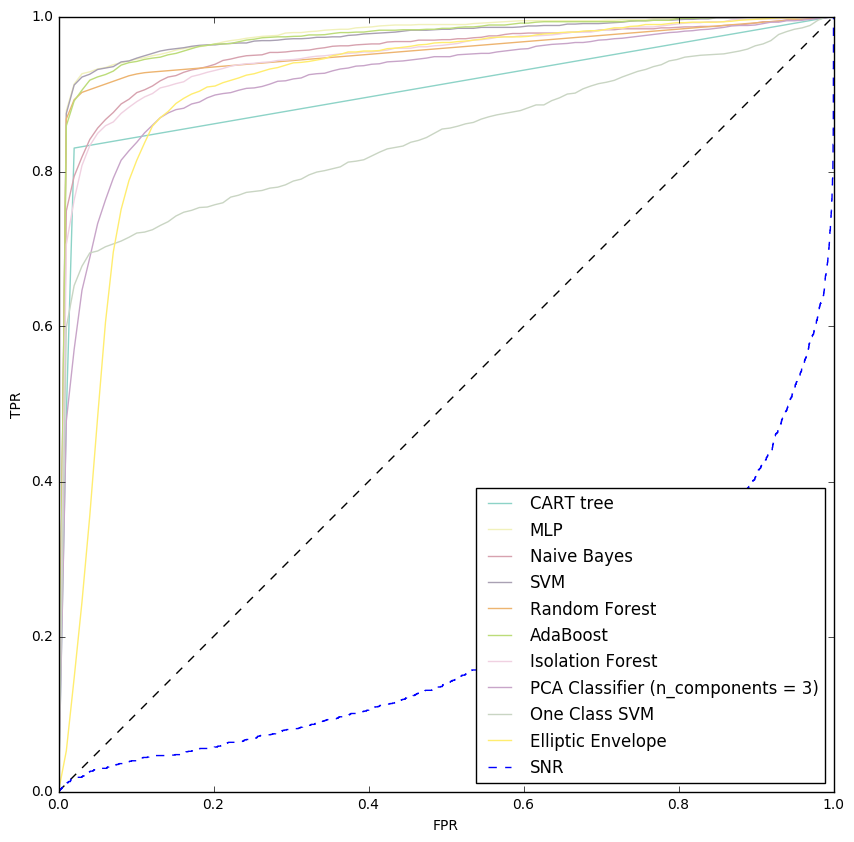

In [15]:
plt.rcParams['figure.figsize'] = 10,10

from matplotlib.cm import get_cmap
f, ax = plt.subplots(1)

cmap = get_cmap('Set3')
colors = [cmap(i) for i in np.linspace(0,1, len(classifiers))]

for (name, clf), col  in zip(classifiers, colors): 
    rscore_mean, rscore_std = mean_roc_curve(clf, X, Y, ax,n_folds = 10, color = col, legend = name)
    print "{} ROC Score: {} +/- {}".format(name, rscore_mean, rscore_std)

#plot the guessing line 
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle = '--', color = 'k')

#add the line for just using an SNR cutoff 
snr = X[:,1]
fpr, tpr, thresholds = roc_curve(Y, snr, pos_label = 1)
ax.plot(fpr,tpr, linestyle = '--', color = 'blue', label = 'SNR')
ax.legend(loc = 'lower right')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

This compares a set of supervised classifiers with the semi-supervised approach in stratified cross validation by comparing their Reciever-Operating Characteristic curves (the true positive rate plotted against the false positive rate). The dotted line indicated equal true and false positive rates (which would be achieved by a classifier that guessed the labels randomly. 
This shows that the semi-supervised approach outperforms a simple decision tree and (perhaps suprisingly) random forest, normally a strong classifier, but is outperformed by naive bayes once TPR's above around 95% are expected, and is outperformed in general by adaboost and mlp. 
That supervised approaches outperform semi-supervised is probably to be expected: the advantage of the isolation forest is that it does not in fact require any positives during training. That it can still achieve similar classification performance to a fully supervised approach (which requires training data to avoid overfitting) is pretty good really.
It does indicate that in practice it might be desirable to gradually transition to a more supervised approach as more training data becomes avaliable. 

It's interesting that only isolation forest significantly outperforms an SNR cutoff.


CART_tree ROC Score: 0.864302884478 +/- 0.115396987101
MLP ROC Score: 0.997814832573 +/- 0.00180363140297
Naive_Bayes ROC Score: 0.988377312587 +/- 0.0108937949259
Random_Forest ROC Score: 0.948573851357 +/- 0.0546614362608
AdaBoost ROC Score: 0.991375969254 +/- 0.0133811691095
IsolationForestClassifier ROC Score: 0.974351884938 +/- 0.0319832001695
IsolationRatioClassifier ROC Score: 0.97123824053 +/- 0.0231413659371


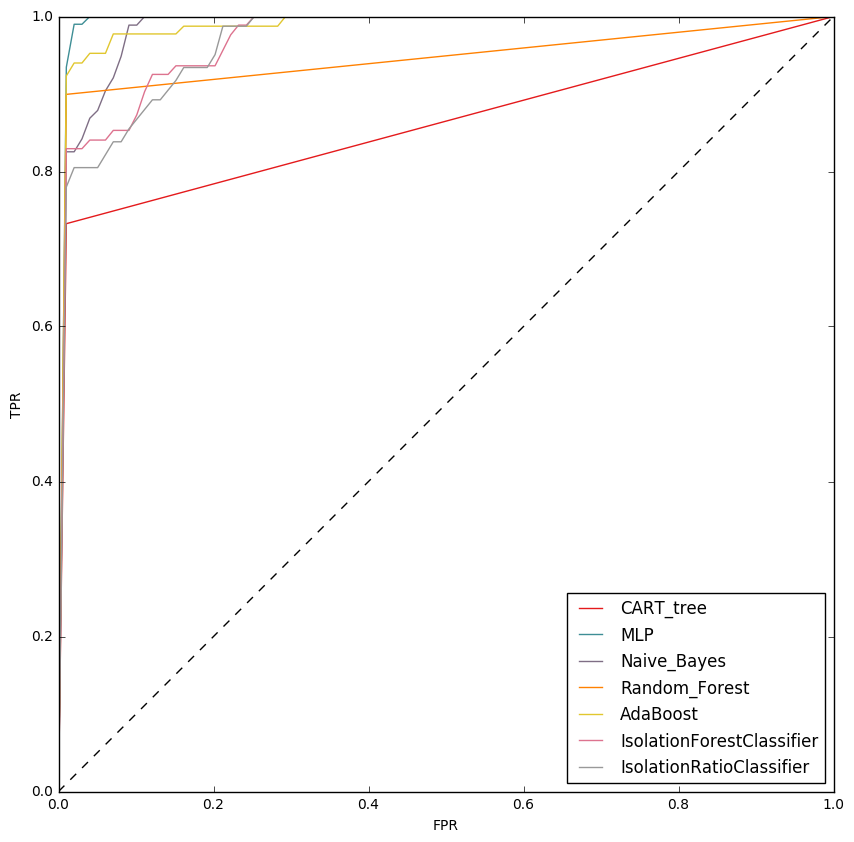

In [8]:
f, ax = plt.subplots(1)
for (name, clf), col  in zip(classifiers, colors): 
    rscore_mean, rscore_std = mean_roc_curve(clf, X, Y, ax,n_folds = 10, color = col, legend = name, stratified = False)
    print "{} ROC Score: {} +/- {}".format(name, rscore_mean, rscore_std)

#plot the guessing line 
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle = '--', color = 'k')
ax.legend(loc = 'lower right')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

Not doing stratifed cross val doesn't hurt the other classifiers as much as I expected: I suppose that the FRB rate is so low it is effectively the same. 


The PCA results suggest that the final field is not particularly useful.. try the other classifiers without it 

In [29]:
!src/MICalc++/micalc frb_datasets/dm_w_grp_n_grp_t_snr_nn_var_widths_discrete.dat

--MI--
4 0.0126401
0 0.00904933
1 0.00491508
12 0.000314758
13 0.000297448
5 0.000289115
8 0.000250348
11 0.00024757
9 0.000246665
10 0.000225018
6 0.000221188
7 0.000214014
14 0.000206102
2 3.3381e-05
3 1.80954e-05
--JMI--
4 0.0126401
0 0.0166097
1 0.0285325
8 0.0274666
2 0.0279905
6 0.0282941
9 0.0287003
12 0.0288765
7 0.0292527
5 0.0296178
13 0.0299896
14 0.0301642
11 0.0304303
10 0.0305331
3 0.0295018
--HD--
1 0.9618
4 0.899261
0 0.882574
5 0.701875
2 0.695558
6 0.616897
3 0.592351
7 0.581696
12 0.573
13 0.572826
8 0.571224
9 0.567209
11 0.566789
10 0.566302
14 0.561349


In [32]:
X_less = X[:,0:-1]
X_less.shape

(15377, 3)

In [33]:
classifiers = []

classifiers.append(("CART_tree", DecisionTreeClassifier()))
classifiers.append(("MLP", Pipeline([('scaler', StandardScaler()), ('mlp',MLPClassifier())])))
classifiers.append(("Naive_Bayes", GaussianNB()))
classifiers.append(("Random_Forest", RandomForestClassifier()))
classifiers.append(("AdaBoost", AdaBoostClassifier()))
classifiers.append(("IsolationForestClassifier", IsolationTreeClassifier(max_samples=8000)))
classifiers.append(("PCA Classifier (n_components = 3)", 
                    Pipeline([('scaler', StandardScaler()), ('pca', PCA_Classifier(n_components = 3))])))
classifiers.append(("PCA Classifier (n_components = 2)", 
                    Pipeline([('scaler', StandardScaler()), ('pca', PCA_Classifier(n_components = 2))])))

CART_tree ROC Score: 0.820807933886 +/- 0.112651611168
MLP ROC Score: 0.997414583512 +/- 0.00242984959901
Naive_Bayes ROC Score: 0.985552881288 +/- 0.0113564790841
Random_Forest ROC Score: 0.942007872167 +/- 0.0454095099808
AdaBoost ROC Score: 0.995459937513 +/- 0.00559252617295
IsolationForestClassifier ROC Score: 0.977384791496 +/- 0.0226512102962
PCA Classifier (n_components = 3) ROC Score: 0.932117538502 +/- 0.0724207888391
PCA Classifier (n_components = 2) ROC Score: 0.931350484021 +/- 0.0796218351832


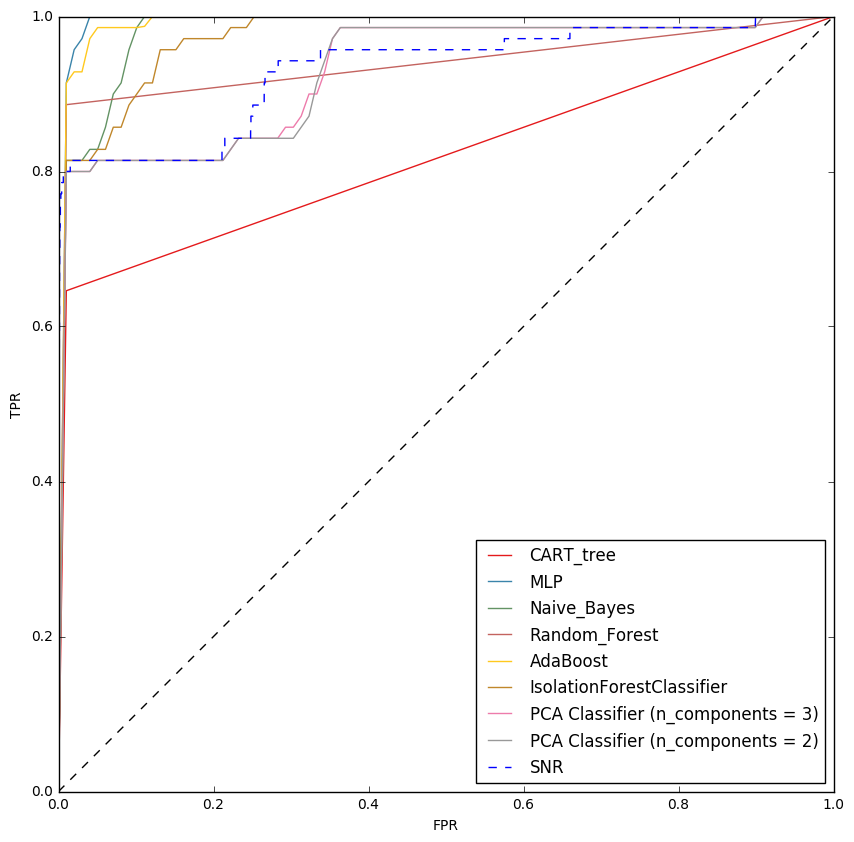

In [36]:
plt.rcParams['figure.figsize'] = 10,10

from matplotlib.cm import get_cmap
f, ax = plt.subplots(1)

cmap = get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0,1, len(classifiers))]

for (name, clf), col  in zip(classifiers, colors): 
    rscore_mean, rscore_std = mean_roc_curve(clf, X_less, Y, ax,n_folds = 10, color = col, legend = name)
    print "{} ROC Score: {} +/- {}".format(name, rscore_mean, rscore_std)

#plot the guessing line 
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle = '--', color = 'k')

#add the line for just using an SNR cutoff 
snr = X[:,1]
fpr, tpr, thresholds = roc_curve(Y, snr, pos_label = 1)
ax.plot(fpr,tpr, linestyle = '--', color = 'blue', label = 'SNR')
ax.legend(loc = 'lower right')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')